In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

## **Cargamos modelo**

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Si cambian dimensiones, ajustamos con conv 1x1
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        
        return out

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.layer1 = ResidualBlock(3, 128)
        self.layer2 = ResidualBlock(128, 64, stride=2)
        self.layer3 = ResidualBlock(64, 64, stride=2)
        self.layer4 = ResidualBlock(64, 64, stride=2)
        self.layer5 = ResidualBlock(64,32,stride = 2)
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = self.pool(x)              
        x = torch.flatten(x, 1)       
        
        x = self.fc(x)                
        
        return x

In [5]:
model = CNN()

In [6]:
model.load_state_dict(torch.load('potatoes_residualCNN.pth'))

<All keys matched successfully>

In [7]:
model.to('cpu')

CNN(
  (layer1): ResidualBlock(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sk

In [8]:
val_transforms = transforms.Compose([
    transforms.Resize(256),           # Mismo resize
    transforms.CenterCrop(224),       # Crop central FIJO (no random)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
idx = {0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}

In [10]:
idx

{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}

## **Predicciones**

In [11]:
def predict(x, model,transforms, device='cpu'):
    """
    Predice la clase de una imagen y muestra visualización con probabilidades
    
    Args:
        x: ruta a la imagen
        model: modelo entrenado
        transforms: transformaciones de preprocesamiento
        idx: diccionario {indice: nombre_clase}
        device: 'cpu' o 'cuda'
    """
    
    # Cargar y preprocesar imagen
    img = Image.open(x).convert("RGB")
    x_tensor = val_transforms(img).unsqueeze(0).to(device)
    
    # Predicción
    model.eval()
    with torch.no_grad():
        outputs = model(x_tensor)
        probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
    
    # Obtener predicción
    pred_idx = int(np.argmax(probs))
    pred_clase = idx[pred_idx]
    confidence = probs[pred_idx] * 100
    
    # Ordenar probabilidades de mayor a menor
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_classes = [idx[i] for i in sorted_indices]
    
    # Crear figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    fig.patch.set_facecolor('white')
    
    # 📷 IZQUIERDA: Imagen original
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Imagen de Entrada', fontsize=14, fontweight='bold', pad=10)
    
    # Añadir recuadro con predicción principal
    ax1.text(0.5, -0.05, f'Predicción: {pred_clase}\nConfianza: {confidence:.2f}%', 
             transform=ax1.transAxes, ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#4CAF50', alpha=0.8, edgecolor='black'),
             color='white')
    
    # 📊 DERECHA: Gráfico de barras de probabilidades
    colors = ['#4CAF50' if i == pred_idx else '#CCCCCC' for i in sorted_indices]
    bars = ax2.barh(range(len(sorted_probs)), sorted_probs * 100, color=colors, edgecolor='black', linewidth=0.5)
    
    # Configurar ejes
    ax2.set_yticks(range(len(sorted_classes)))
    ax2.set_yticklabels([c.replace('___', ' ').replace('__', ' ') for c in sorted_classes], fontsize=10)
    ax2.set_xlabel('Probabilidad (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Distribución de Probabilidades', fontsize=14, fontweight='bold', pad=10)
    ax2.set_xlim(0, 100)
    
    # Añadir valores en las barras
    for i, (bar, prob) in enumerate(zip(bars, sorted_probs)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{prob*100:.2f}%', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Invertir eje Y para que la mayor probabilidad esté arriba
    ax2.invert_yaxis()
    
    # Grid horizontal
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
   

La función de predicción tiene como objetivo analizar una imagen de una hoja de papa y estimar la probabilidad de pertenencia a cada una de las clases de enfermedad consideradas por el modelo (Early Blight, Late Blight y Healthy).

Para ello, la imagen ingresada por el usuario es sometida primero a un proceso de preprocesamiento que replica exactamente las transformaciones utilizadas durante el entrenamiento del modelo, incluyendo redimensionamiento, normalización y conversión a tensor. Posteriormente, la imagen es enviada a la red neuronal convolucional entrenada, la cual genera un conjunto de valores de salida (logits).

Estos valores son transformados mediante la función Softmax, permitiendo convertir las salidas del modelo en probabilidades interpretables. Como resultado, la función devuelve la distribución probabilística asociada a cada enfermedad, indicando el nivel de confianza del modelo para cada clase.

Este enfoque no solo proporciona la clase predicha, sino también una medida cuantitativa de certeza, lo que facilita la interpretación del diagnóstico y permite visualizar qué tan probable es la presencia de cada enfermedad en la hoja analizada.

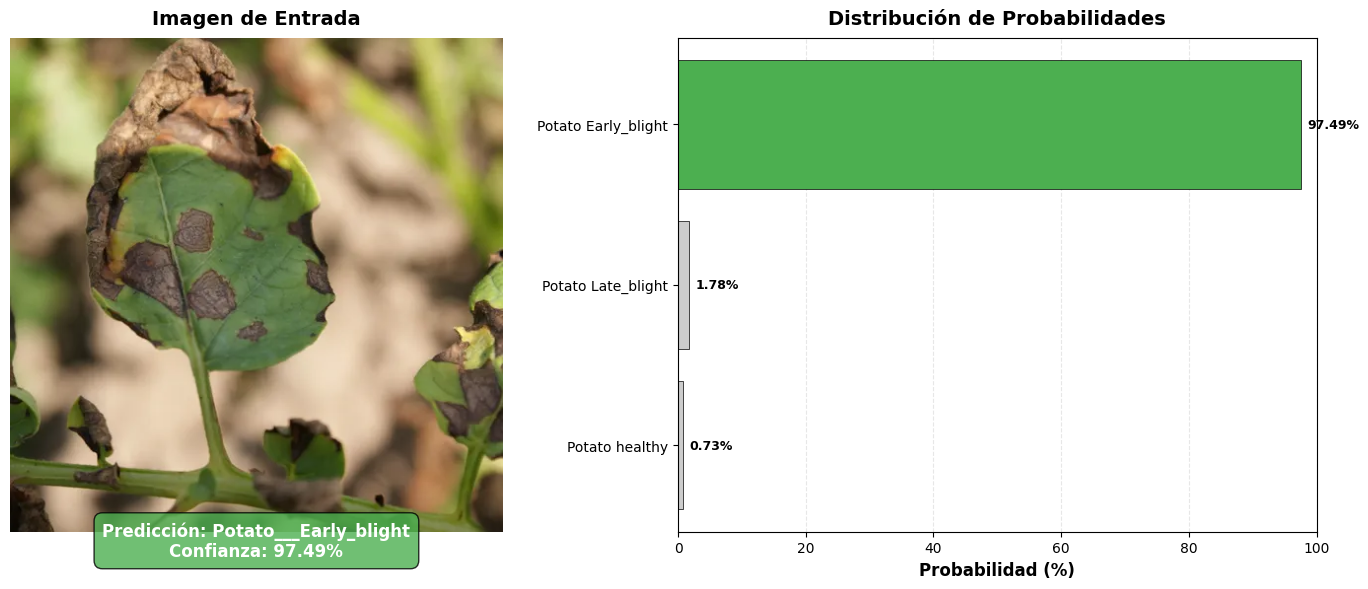

In [14]:

# Llamar a la función
ruta_imagen = r"C:\Users\Chucho\Downloads\ca2020_early_blight_potato_damage2.webp"
predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

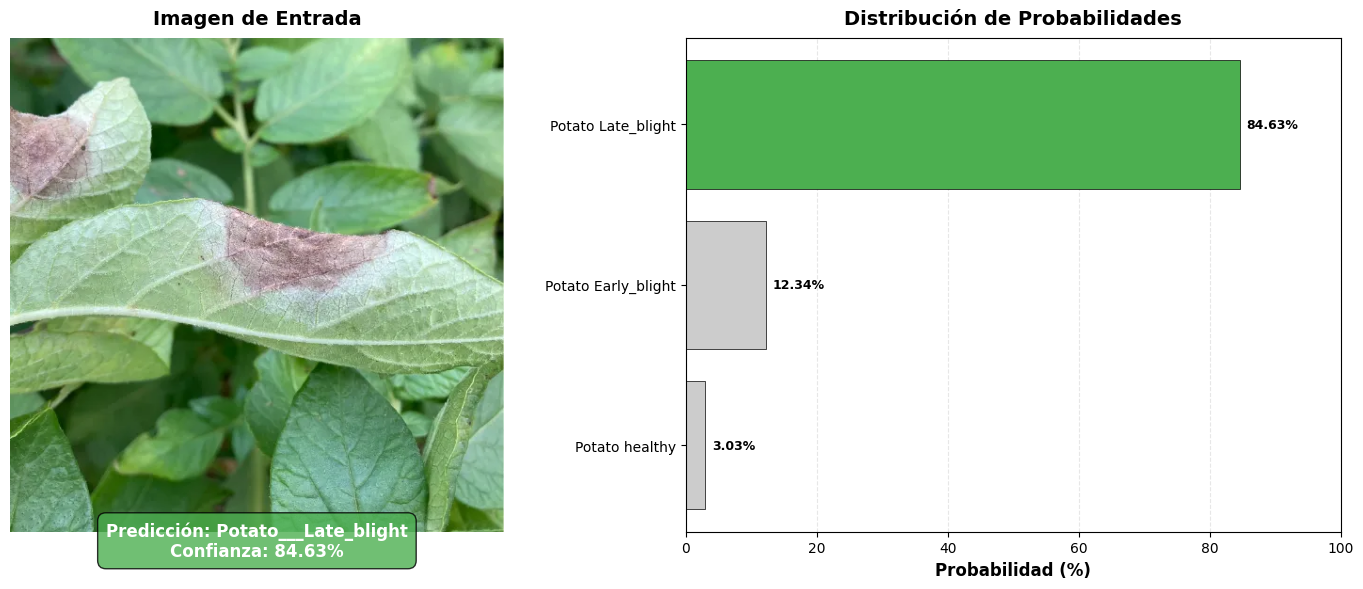

In [15]:
ruta_imagen = r"C:\Users\Chucho\Downloads\ca2024_potato_late_blight.webp"
predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

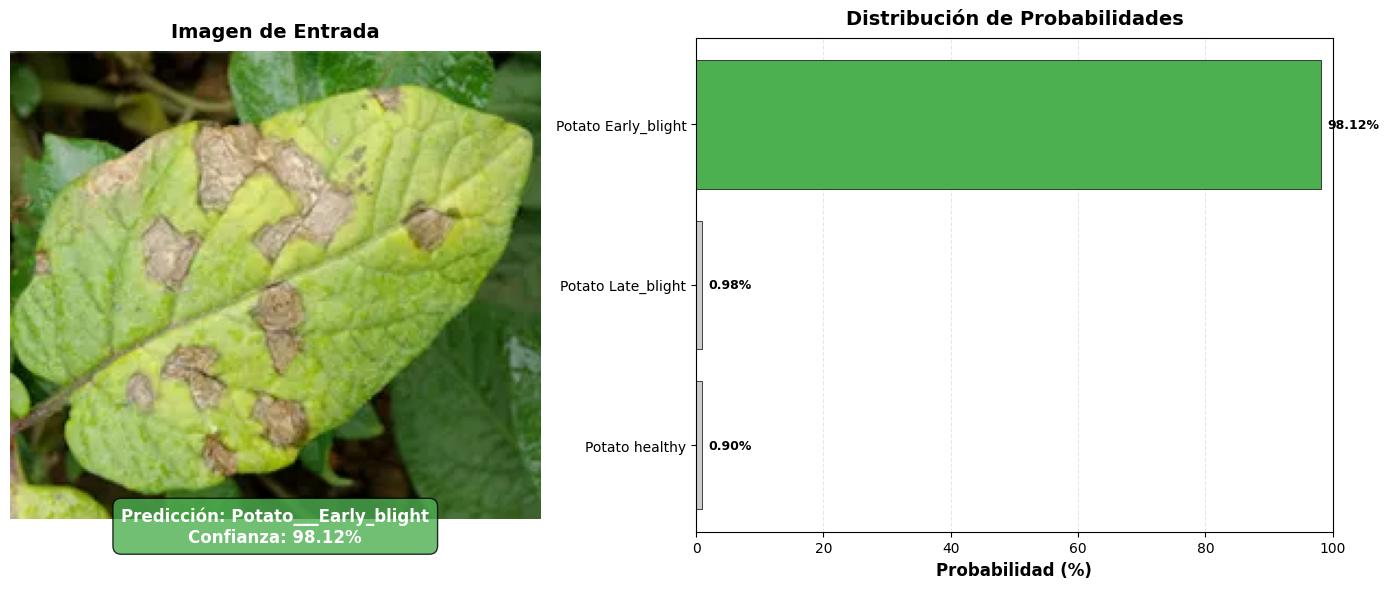

In [18]:
ruta_imagen = r"C:\Users\Chucho\Downloads\2.earlyblight1.webp"
predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

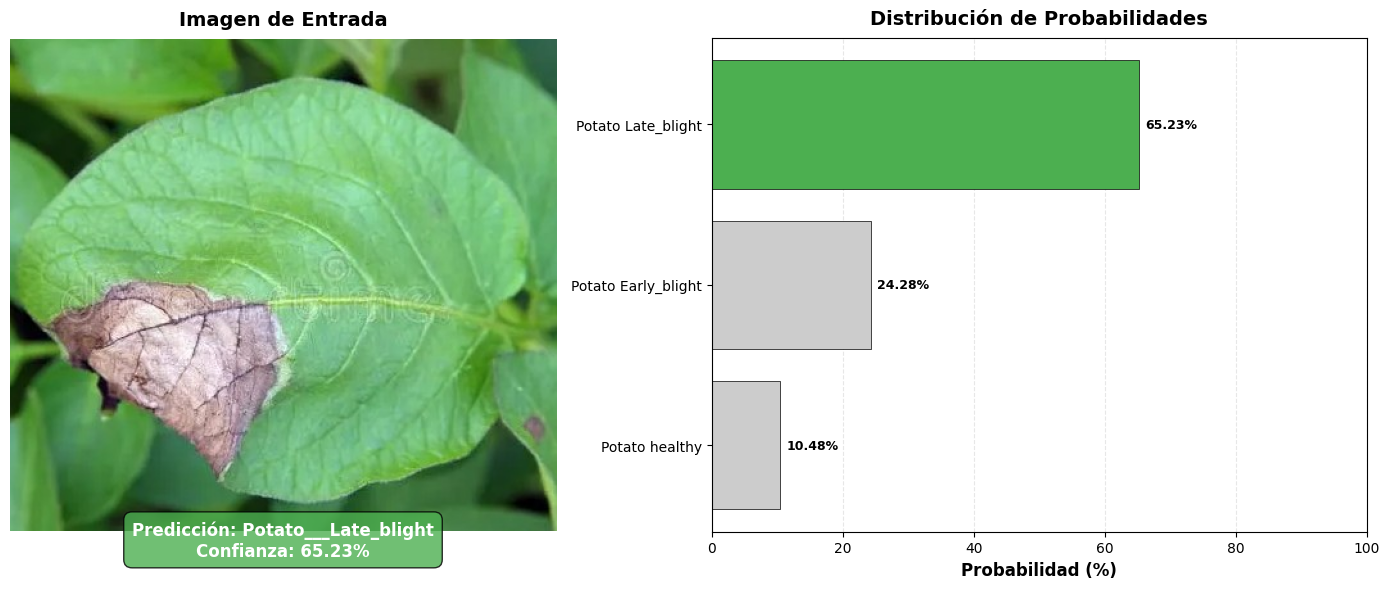

In [16]:
ruta_imagen = r"C:\Users\Chucho\Downloads\potato-late-blight-disease-symptom-fungi-potato-late-blight-disease-symptom-fungi-major-disease-phytophtora-infestan-242773707.jpg"
predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)